## Calculating a seats-votes curve using uniform partisan swing

The goal of this little experiment is to see if I can generate a seats-votes curve for test map of just Fairfax County.

In [1]:
library(sf)
library(ggplot2)
library(tidyverse)
library(tibble)
library(magrittr)
library(redist)
library(pscl)
library(sp)
library(spData)
library(spdep)
library(igraph)

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract


Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis


Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The follo

In [2]:
# read in DC data
df <- st_read("C:/Users/madie/OneDrive/data/VA-2017/Fairfax_precincts/Fairfax_precincts.shp")

Reading layer `Fairfax_precincts' from data source `C:\Users\madie\OneDrive\data\VA-2017\Fairfax_precincts\Fairfax_precincts.shp' using driver `ESRI Shapefile'
Simple feature collection with 249 features and 57 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 170404.1 ymin: 291609.7 xmax: 213724.5 ymax: 341555.9
projected CRS:  Lambert_Conformal_Conic


In [3]:
# reformat for MCMC
# copy over useful cols and rename them
df <- df %>%
    select(geoid10 = geoid10,
           pop = TOTPOP,
           vap = VAP,
           obama = G17DHOD,
           mccain = G17RHOD,
           TotPop = TOTPOP,
           BlackPop = NH_BLACK,
           HispPop = HISP,
           VAP_1 = VAP,
           BlackVAP = BVAP,
           HispVAP = HVAP,
           geometry = geometry)
# change all cols to numeric type
df %<>% 
      mutate_each(funs(if(is.character(.)) as.numeric(.) else .))
print(df)

Warning message:
"`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."
Warning message:
"`mutate_each_()` is deprecated as of dplyr 0.7.0.
Please use `across()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


Simple feature collection with 249 features and 11 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 170404.1 ymin: 291609.7 xmax: 213724.5 ymax: 341555.9
projected CRS:  Lambert_Conformal_Conic
First 10 features:
   geoid10  pop  vap obama mccain TotPop BlackPop HispPop VAP_1 BlackVAP
1     1580 1236  950   344    220   1236       35      57   950       24
2     1581 7218 6003  1451      0   7218      467     742  6003      367
3     1582 3016 2345   702    199   3016       63    1332  2345       42
4     1583 3395 2673   881    334   3395      201     930  2673      141
5     1584 3774 3050   761    372   3774      291     797  3050      218
6     1585 4239 3254   978    424   4239      481     769  3254      340
7     1586 5521 4113   198     44   5521       68    4655  4113       49
8     1587 6215 4816  1319    380   6215     1325    1667  4816      961
9     1588 7072 5340  1368    375   7072     1476    2544  5340     1038
10    1589 3680 2943  1023   

In [4]:
# compute adjaceny list
adjlist <- redist.adjacency(df)

## Test with MCMC

In [ ]:
# Run a chain
alg_mcmc <- redist.mcmc(adjobj = adjlist,
                        popvec = df$pop,
                        ndists = 10,
                        nsims = 10000,
                        maxiterrsg = 5000)

In [16]:
# generate 10 random colors that are distinct so that the different districts are distinguishable. 
library(randomcoloR)
colors <- distinctColorPalette(k=10)

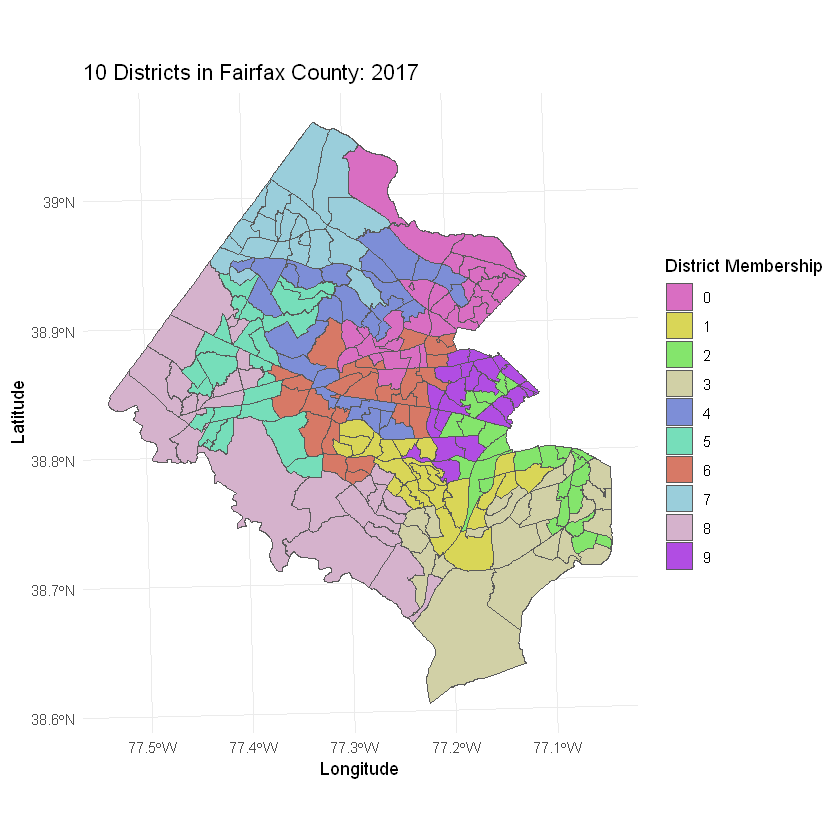

In [17]:
# Let's plot this!
cds <- alg_mcmc$partitions[,1]
plot <- redist.map(shp=df, 
        district_membership=cds, 
        centroids=FALSE, 
        edges=FALSE,
        title="10 Districts in Fairfax County: 2017") +
        theme(legend.position="right") +
        scale_fill_manual(values = colors)
plot

Warning message in if (measure == "all") {:
"the condition has length > 1 and only the first element will be used"
Warning message in par(oldpar):
"graphical parameter "cin" cannot be set"
Warning message in par(oldpar):
"graphical parameter "cra" cannot be set"
Warning message in par(oldpar):
"graphical parameter "csi" cannot be set"
Warning message in par(oldpar):
"graphical parameter "cxy" cannot be set"
Warning message in par(oldpar):
"graphical parameter "din" cannot be set"
Warning message in par(oldpar):
"graphical parameter "page" cannot be set"


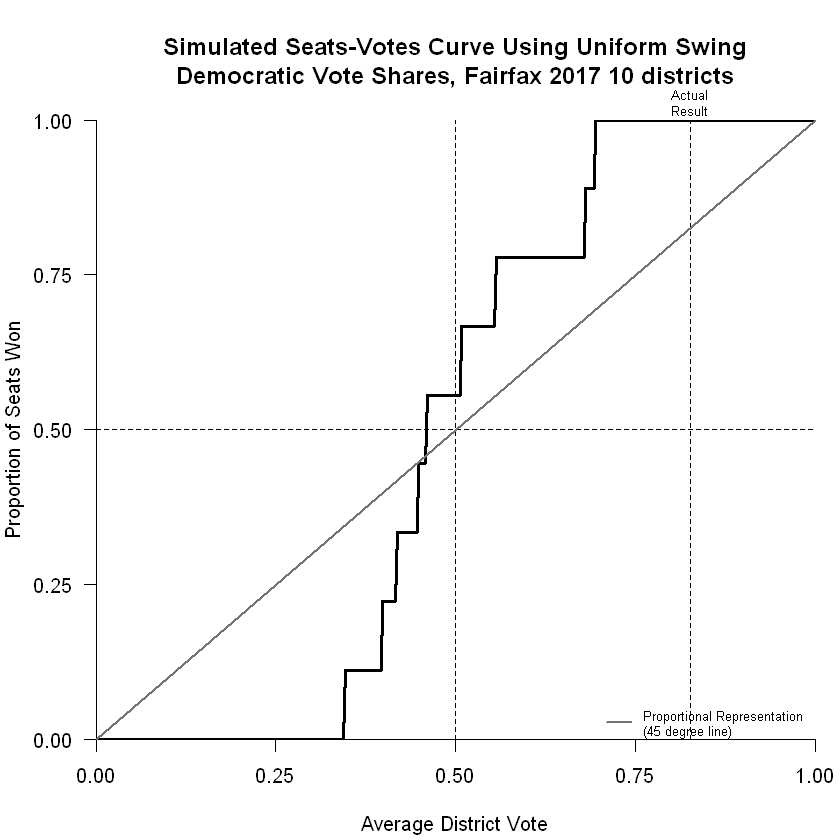

In [26]:
# compute the percent of votes won by democrats in each district under DVS
plot_sv <- redist.metrics(cds, measure = c("DSeats", "DVS"), df$mccain, dvote = df$obama) %>% 
           # extract DVS into vector
           pull(DVS) %>%
           # calculate seats-votes curve using uniform partisan swing
           seatsVotes(desc="Democratic Vote Shares, Fairfax 2017 10 districts") %>%
           # plot the seats-votes curve
           plot(type="seatsVotes")

Fascinating! It appears that my entirely fake 10 districts for Fairfax city and county slightly favor the Democrats. This is so cool!

## Test with SMC

In [5]:
alg_smc <- redist.smc(adjobj = adjlist,
                        popvec = df$pop,
                        ndists = 10,
                        nsims = 10000)

Sampling 10000 249-unit maps with 10 districts and population tolerance 1%.
Making split 1 of 9
Using k=2 for estimated success probability of 26.68%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

9693 valid samples (25.9% of total)
Making split 2 of 9
Using k=2 for estimated success probability of 20.75%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

11561 valid samples (24.0% of total)
Making split 3 of 9
Using k=2 for estimated success probability of 22.13%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

9720 valid samples (21.5% of total)
Making split 4 of 9
Using k=2 for estimated success probability of 20.95%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

9293 valid samples (19.5% of total)
Making split 5 of 9
Using k=2 for estimated success probability of 16.60%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

10832 valid samples (18.0% of total)
Making split 6 of 9
Using k=2 for estimated success probability of 15.81%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

10299 valid samples (16.3% of total)
Making split 7 of 9
Using k=2 for estimated success probability of 16.40%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

8812 valid samples (14.5% of total)
Making split 8 of 9
Using k=2 for estimated success probability of 10.28%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

10962 valid samples (11.3% of total)
Making split 9 of 9
Using k=2 for estimated success probability of 9.88%


Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"printing of extremely long output is truncated"
Warning message in smc_plans(nsims, adjlist, counties, popvec, ndists, popcons, :
"

7708 valid samples (3.9% of total)


Warning message in redist.smc(adjobj = adjlist, popvec = df$pop, ndists = 10, nsims = 10000):
"Fewer maps sampled than requested; try increasing `max_oversample`."


ERROR while rich displaying an object: Error: Insufficient values in manual scale. 10 needed but only 1 provided.

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.d

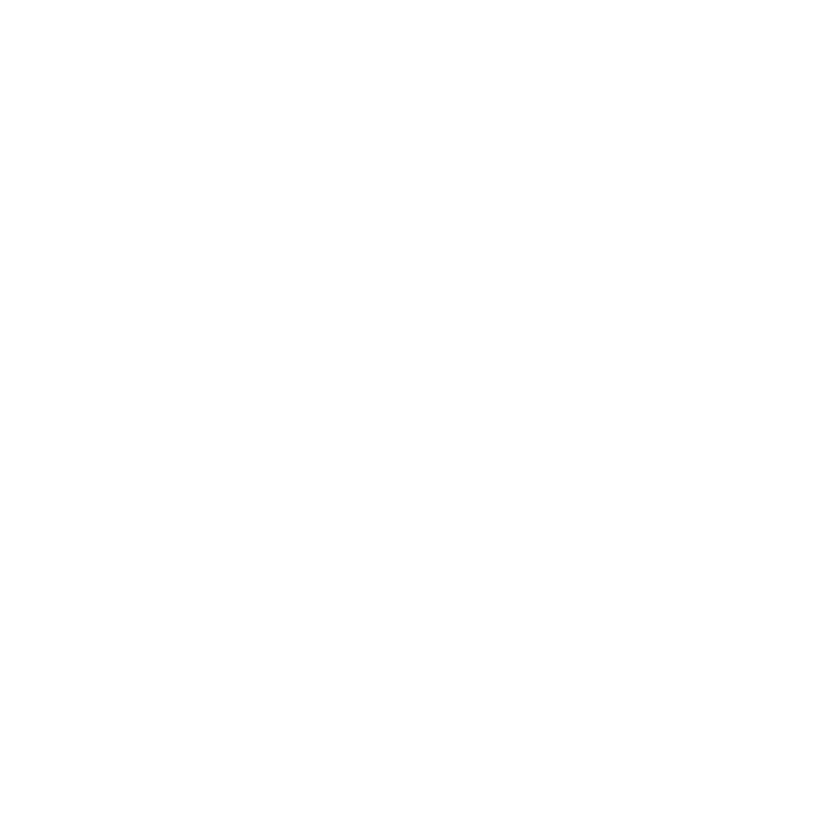

In [6]:
# Let's plot this!
cds_smc <- alg_smc$cdvec[,1]
plot <- redist.map(shp=df, 
        district_membership=cds_smc, 
        centroids=FALSE, 
        edges=FALSE,
        title="10 Districts in Fairfax County: SMC 2017") +
        theme(legend.position="right") +
        scale_fill_manual(values = colors)
plot

Warning message in if (measure == "all") {:
"the condition has length > 1 and only the first element will be used"
Warning message in par(oldpar):
"graphical parameter "cin" cannot be set"
Warning message in par(oldpar):
"graphical parameter "cra" cannot be set"
Warning message in par(oldpar):
"graphical parameter "csi" cannot be set"
Warning message in par(oldpar):
"graphical parameter "cxy" cannot be set"
Warning message in par(oldpar):
"graphical parameter "din" cannot be set"
Warning message in par(oldpar):
"graphical parameter "page" cannot be set"


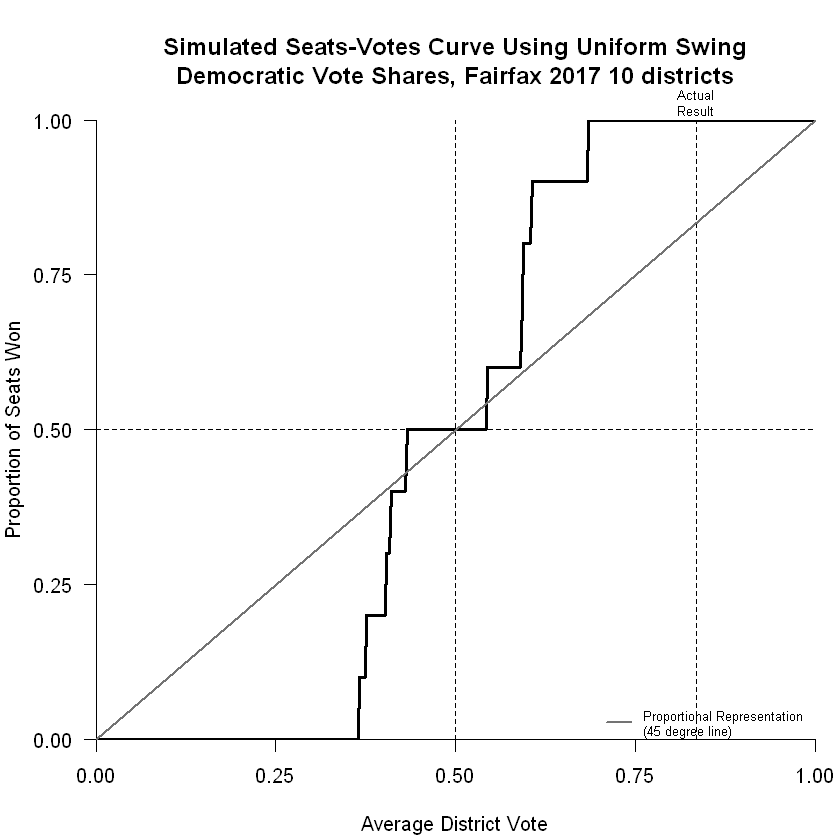

In [30]:
# compute the percent of votes won by democrats in each district under DVS
plot_smc_sv <- redist.metrics(cds_smc, measure = c("DSeats", "DVS"), df$mccain, dvote = df$obama) %>% 
           # extract DVS into vector
           pull(DVS) %>%
           # calculate seats-votes curve using uniform partisan swing
           seatsVotes(desc="Sample Seats-Votes Curve generated using Uniform Partisan Swing") %>%
           # plot the seats-votes curve
           plot(type="seatsVotes")

Interesting! In this instance, SMC seems to have produced a set of districts that have 0 partisan bias (the seats votes curve goes through the point (0.5, 0.5)). 